### Regression Task

##### "Charges" variable will be dependant one. The variables describes the amount of insurance payment due to different factors such as sex, bmi, children, smoker status and region.

In [155]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

np.random.seed(0)

In [156]:
path_to_data = "insurance.csv"
df = pd.read_csv(path_to_data) # Load the data
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [157]:
df['sex'] = (df.sex == "male").astype('int')

In [158]:
df['smoker'] = (df.smoker == "yes").astype('int')

In [159]:
df.drop(['region'], axis='columns', inplace=True)

In [160]:
df

,age,sex,bmi,children,smoker,charges
0,19,0,27.900,0,1,16884.92400
1,18,1,33.770,1,0,1725.55230
2,28,1,33.000,3,0,4449.46200
3,33,1,22.705,0,0,21984.47061
4,32,1,28.880,0,0,3866.85520
...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830
1334,18,0,31.920,0,0,2205.98080
1335,18,0,36.850,0,0,1629.83350
1336,21,0,25.800,0,0,2007.94500


##### "Charges" variable will be dependant one. The variables describes the amount of insurance payment due to different factors

In [161]:
X = df.loc[:, ~df.columns.isin(['charges'])]
Y = df['charges']

X.shape, Y.shape

((1338, 5), (1338,))

In [162]:
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1070, 5), (1070,), (268, 5), (268,))

In [163]:
# Build the model with the random forest regression algorithm:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=0)

### Analysis with SHAP

In [164]:
import shap

shap.initjs()

In [165]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

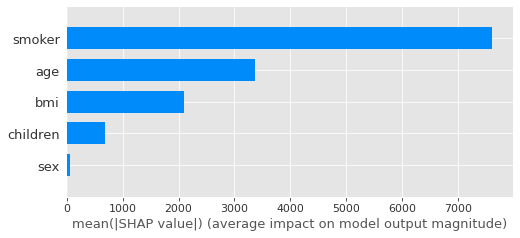

In [166]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

##### We see the most significant contribution of the dummy variable `smoker` which means it is the most important one for the dependant variable.

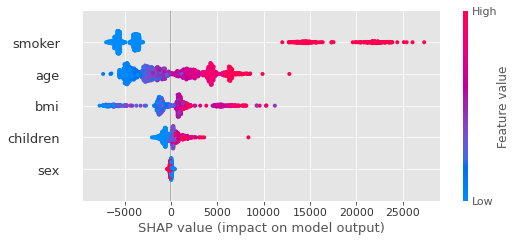

In [167]:
shap.summary_plot(shap_values, X_train)

##### A high level of the “smoker” content has a high and positive impact on the charge. Smoker is also the most radical factor. Other variables are not that significant: age, bmi and children have quite normally distributed impact. And no correlation with sex.

In [168]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train)

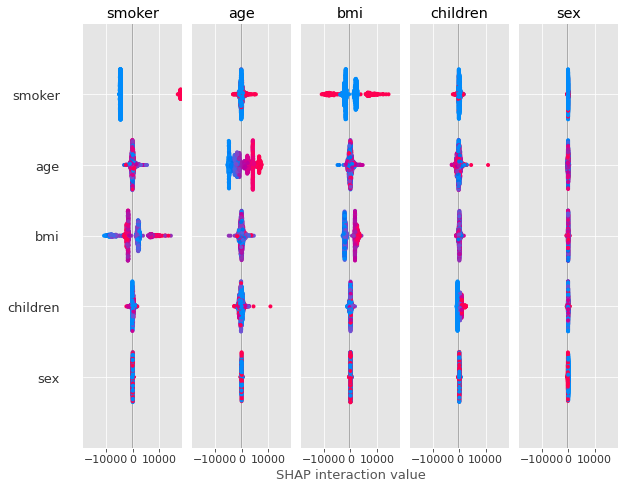

In [169]:
shap.summary_plot(shap_interaction_values, X_train)

In [170]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train)

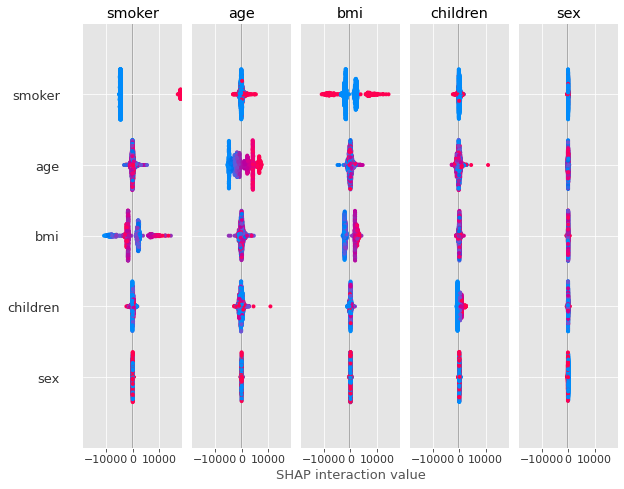

In [171]:
shap.summary_plot(shap_interaction_values, X_train)

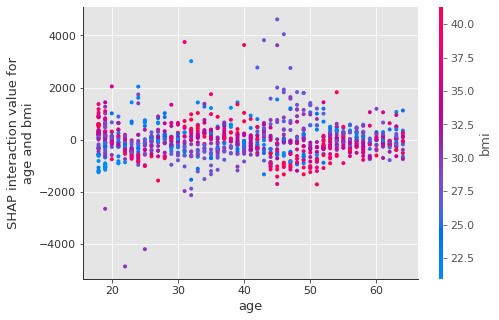

In [172]:
shap.dependence_plot(
    ("age", "bmi"),
    shap_interaction_values, X_train,
    display_features=X_train
)

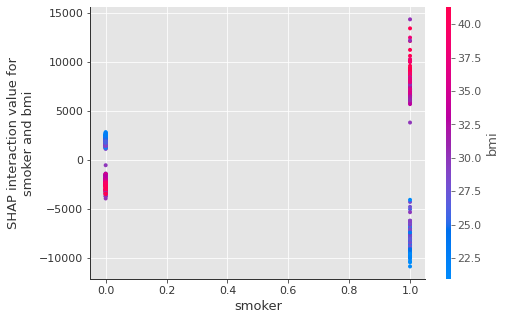

In [173]:
shap.dependence_plot(
    ("smoker", "bmi"),
    shap_interaction_values, X_train,
    display_features=X_train
)

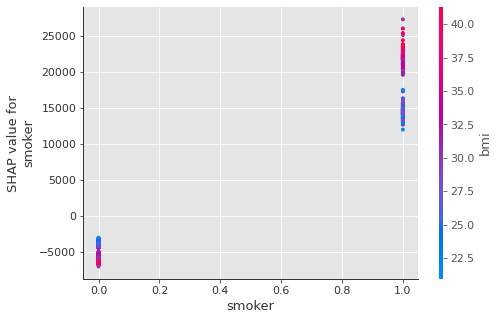

In [174]:
shap.dependence_plot("smoker", shap_values, X_train)

##### As we observed the most significant variable to be "smoker" I decided to examine it mostly. We see that smoker has the biggest interaction with bmi which is very interesting. Also the dependance plot tells us whak kind of relationship exists between feature and target variable. Here because smoker variable is dummy we have only extreme values 0 and 1 but still we observe strongly positive relationship trend.

In [176]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

### Permutation Importance

In [177]:
feature_names = [i for i in df.columns]

In [178]:
feature_names.pop()

'charges'

In [179]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_test, Y_test)
eli5.show_weights(perm, feature_names =feature_names)

Weight,Feature
1.3593 ± 0.1010,smoker
0.2373 ± 0.0678,bmi
0.1981 ± 0.0507,age
0.0086 ± 0.0051,children
0.0006 ± 0.0011,sex


##### Permutation importance didn't show any negative values which means that all our features are important but of course have different significance level . The most important is 'smoker' feature, then bmi and age.
##### With PDP we can observe HOW those features affect out dependant variable.

### PDP

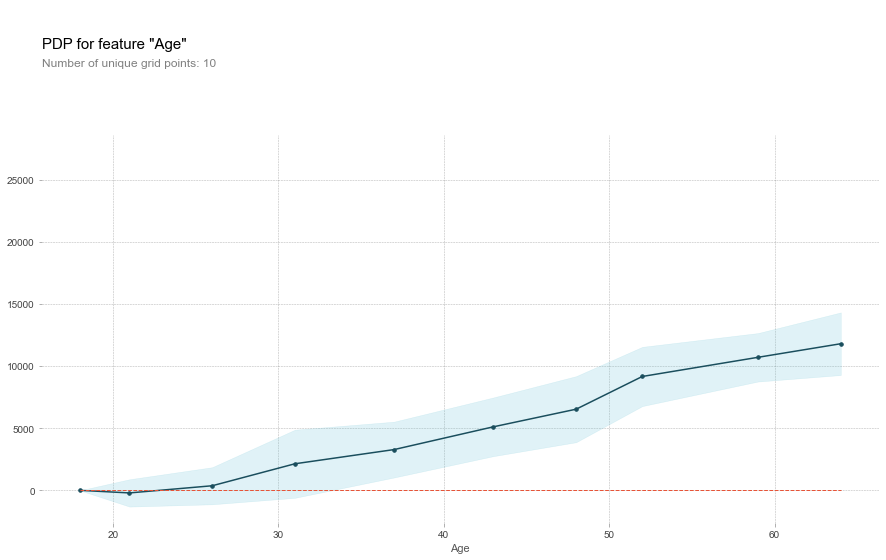

In [180]:
from matplotlib import pyplot as plt
from pdpbox import pdp

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model, dataset=X_test, model_features=feature_names, feature='age')

# plot it
pdp.pdp_plot(pdp_goals, 'Age')
plt.show()

In [181]:
def build_pdp(feature_to_plot):
    pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=feature_names, feature=feature_to_plot)

    pdp.pdp_plot(pdp_dist, feature_to_plot)
    plt.show()


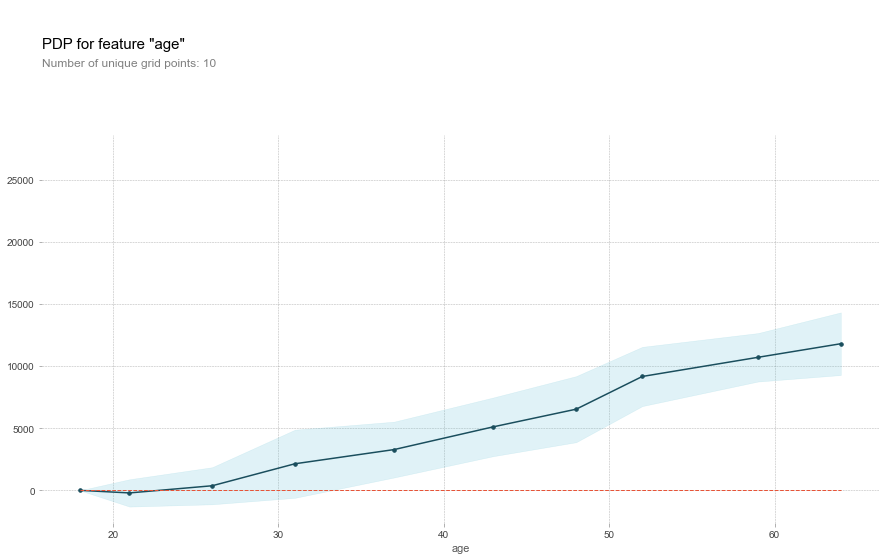

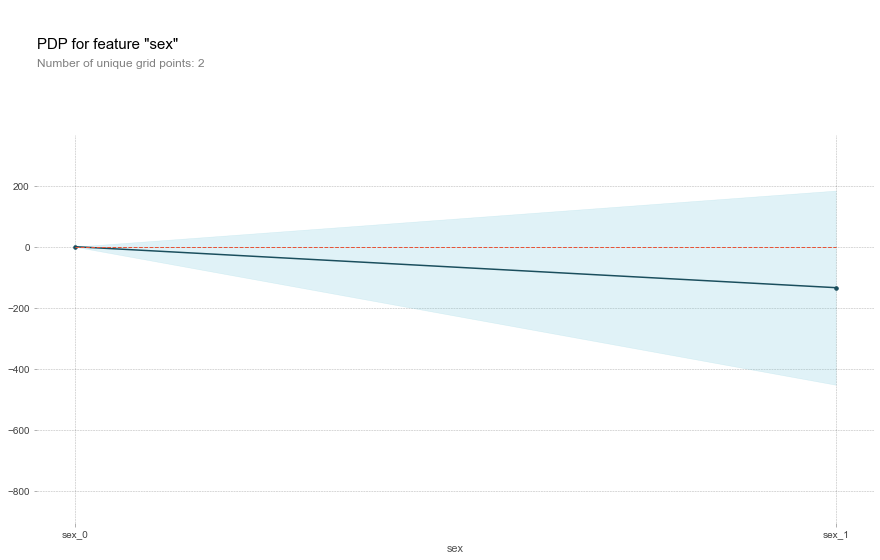

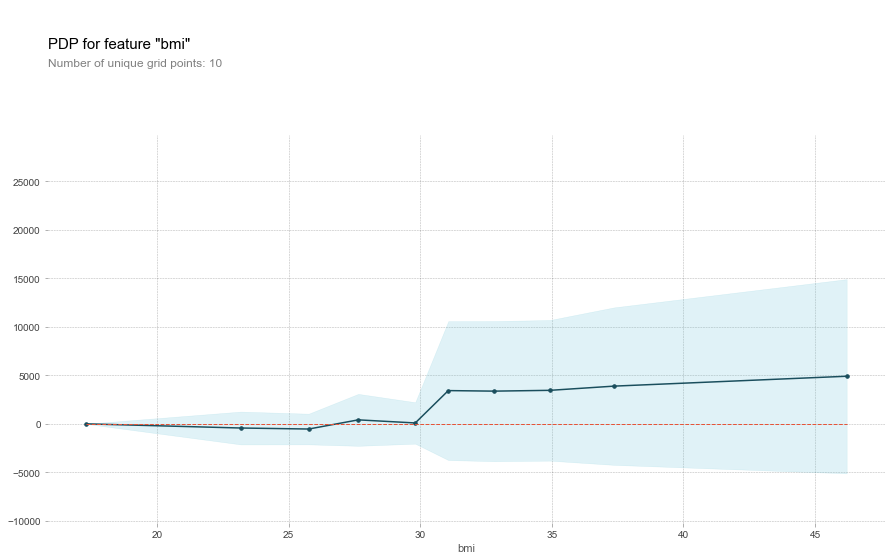

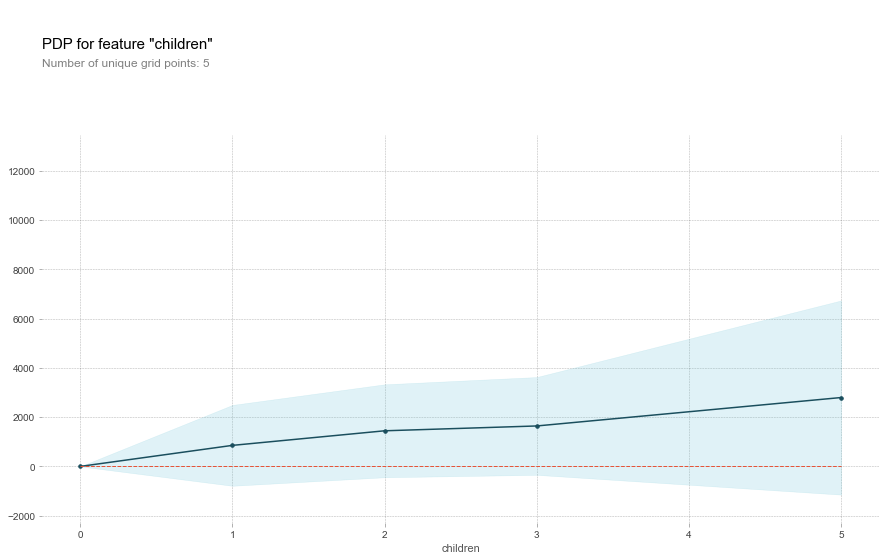

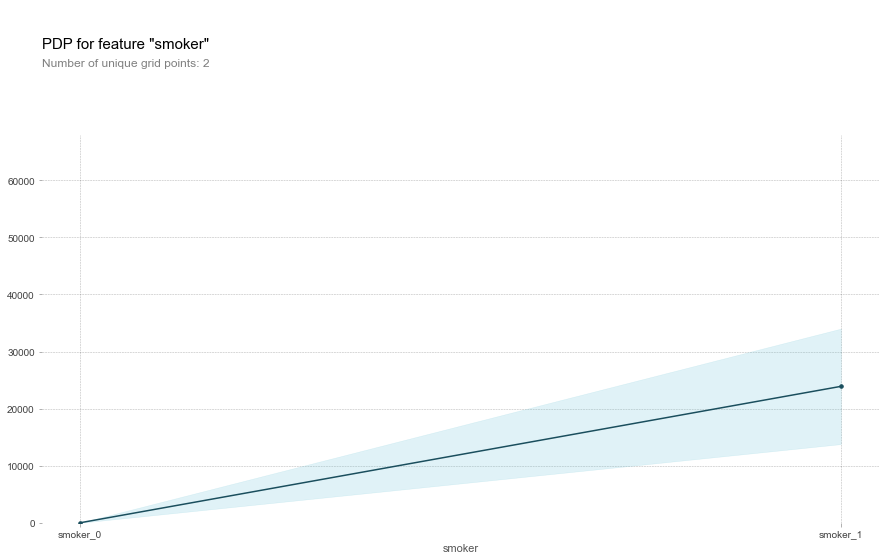

In [182]:
for i in feature_names:
    build_pdp(i)

### Correlation analysis

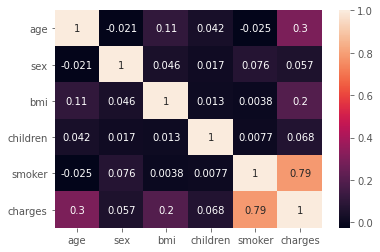

In [183]:

import seaborn as sn
import matplotlib.pyplot as plt
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

#### This correlation matrix again proves our previos analysis and shows the most signifact correlation between smoking status of the person and its influence on isurance payment. All the factor have more or less positive influence on dependant variable, however not all the features are correlated between each other. 

# Task 4

In [184]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier


In [185]:
df_list = []
df = pd.read_csv('IMDB Dataset.csv')

In [186]:
df['sentiment'] = (df.sentiment == "positive").astype('int')

In [187]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [188]:
sentences = df['review'].values
y = df['sentiment'].values

In [189]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [190]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

KeyboardInterrupt: 

In [ ]:
X_train

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

In [ ]:
input_dim = X_train.shape[1]

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))